In [302]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scraping import get_element_from_selector, get_info_from_job, get_page_of_attributes, scrape_ds, scrape_glassdoor_url, css_mappings
#from clean_salaries import filter_jobs_with_salaries, create_salaries_cols
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [2]:
import pandas as pd
blacklisted_occupations = ['physician', 'dentist', 'psychiatrist', 'pediatrician', 'oncologist', 'crna', 'surgeon', 'anesthesiologist', 'neurologist', 'hospitalist']

def filter_jobs_with_salaries(df,salary_col):
    #must have salary range
    tempdf=df[df[salary_col].notnull()]
    #must not be hourly, shortcut look for 'K'
    tempdf=tempdf[tempdf['salary_range'].str.find('K')>0]
    tempdf=tempdf[tempdf['salary_range'].str.find('Employer Provided Salary:')<0]
    return tempdf
def create_salaries_cols(df,salary_col):
    '''
    parses salary range column, removes formatting, and splits to upper, lower bounds, and salary estimate type
    returns dataframe with cleansed salary format
    '''
    tempdf = df['salary_range'].str.replace('$','')
    tempdf = tempdf.str.split('K', expand=True)
    tempdf.columns = ['salary_lower','salary_upper','salary_estimator']
    tempdf['salary_upper'] = tempdf['salary_upper'].str.replace('-','')
    numeric_cols = ['salary_lower','salary_upper']
    tempdf[numeric_cols]=tempdf[numeric_cols].apply(pd.to_numeric)
    df=pd.concat([df,tempdf],axis=1)
    df=df.drop(columns=[salary_col])
    return df

def convert_salaries_hourly(df,salary_col):
    hourly=df[df['salary_range'].str.lower().str.find('per hour')>0]['salary_range']
    hourly=hourly.str.replace('Employer Provided Salary:','')
    hourly=hourly.str.replace('Per Hour','')
    hourly=hourly.str.replace("Glassdoor Est.",'')
    hourly=hourly.str.replace("\(\)","")
    hourly=hourly.str.replace('$','')
    hourly=hourly.str.split('-',expand=True)
    hourly.columns=['salary_lower','salary_upper']
    numeric_cols = ['salary_lower','salary_upper']
    hourly[numeric_cols]=hourly[numeric_cols].apply(pd.to_numeric)
    return df

In [14]:
dfds=pd.read_csv('/Users/michaelpalmer/galvanize/level-up/ds_30.csv', sep='|')

In [15]:
dfds.drop(columns='Unnamed: 0', inplace=True)

In [16]:
dfds.head()

,job_title,job_description,stars,salary_range
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,$120K-$170K (Glassdoor Est.)
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,$90K-$127K (Glassdoor Est.)
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,$120K-$169K (Glassdoor Est.)
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,$108K-$155K (Glassdoor Est.)
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,$118K-$173K (Glassdoor Est.)


In [524]:
dfclean = filter_jobs_with_salaries(dfds,'salary_range')
dfclean = create_salaries_cols(dfclean,'salary_range')
dfclean.reset_index(inplace=True, drop=True)

In [525]:
#dfclean.reset_index
dfclean

,job_title,job_description,stars,salary_lower,salary_upper,salary_estimator
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,120,170,(Glassdoor Est.)
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,90,127,(Glassdoor Est.)
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,120,169,(Glassdoor Est.)
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,108,155,(Glassdoor Est.)
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,118,173,(Glassdoor Est.)
5,Data Scientist,At a time when healthcare reform is on the nat...,4.0 ★,119,170,(Glassdoor Est.)
6,Data Architect,Yesler is looking for an expert Data Architect...,4.4 ★,83,120,(Glassdoor Est.)
7,Data Scientist,Who we are:\n\nRover.com connects pet parents ...,4.5 ★,82,121,(Glassdoor Est.)
8,Bioinformatics Scientist,We are seeking a Bioinformatics Scientist for ...,3.2 ★,88,118,(Glassdoor Est.)
9,Data Scientist,The Intelligent Conversation and Communication...,4.1 ★,118,160,(Glassdoor Est.)


In [373]:
cvec=CountVectorizer(stop_words='english')
cvec.fit(dfclean['job_description'])
bag_of_words=cvec.transform(dfclean['job_description'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     cvec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#return words_freq[:n]

In [376]:
arr=np.array(words_freq[:20])
X=arr[:,0]
y=arr[:,1]
y=y.astype(int)

Text(0.5,1,'Term Frequency in Data Science Job Postings')

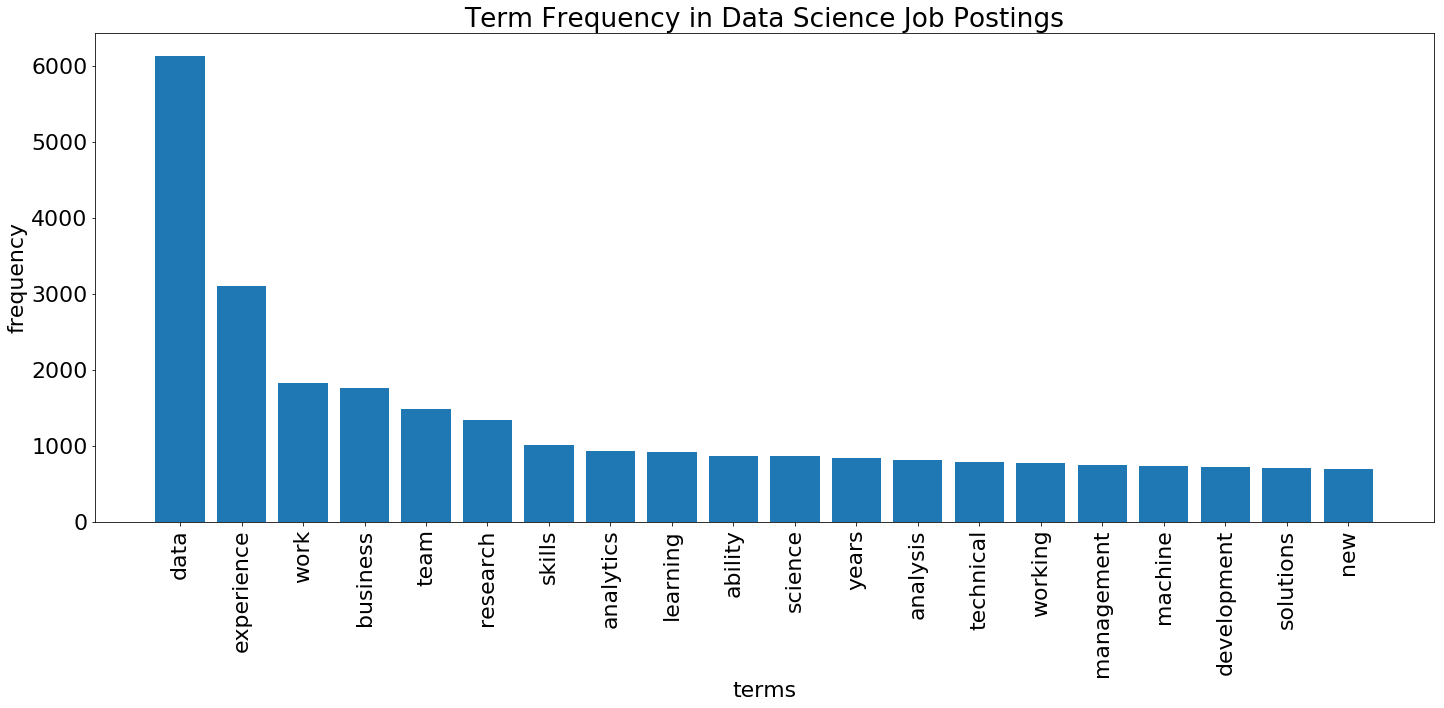

In [377]:
fig, ax = plt.subplots(figsize=(24,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('frequency')
ax.set_title('Term Frequency in Data Science Job Postings')

In [365]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')

In [366]:
bag_of_words = tfidf.fit_transform(dfclean['job_description'])

/Users/michaelpalmer/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [367]:
bag_of_words

<609x3683 sparse matrix of type '<class 'numpy.float64'>'
	with 133938 stored elements in Compressed Sparse Row format>

In [370]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(bag_of_words.toarray()).flatten()[::-1]

n = 20
X = feature_array[tfidf_sorting][:n]
y = np.sort(bag_of_words.toarray()).flatten()[::-1]
y=y[:n]

Text(0.5,1,'TFIDF in Data Science Job Postings')

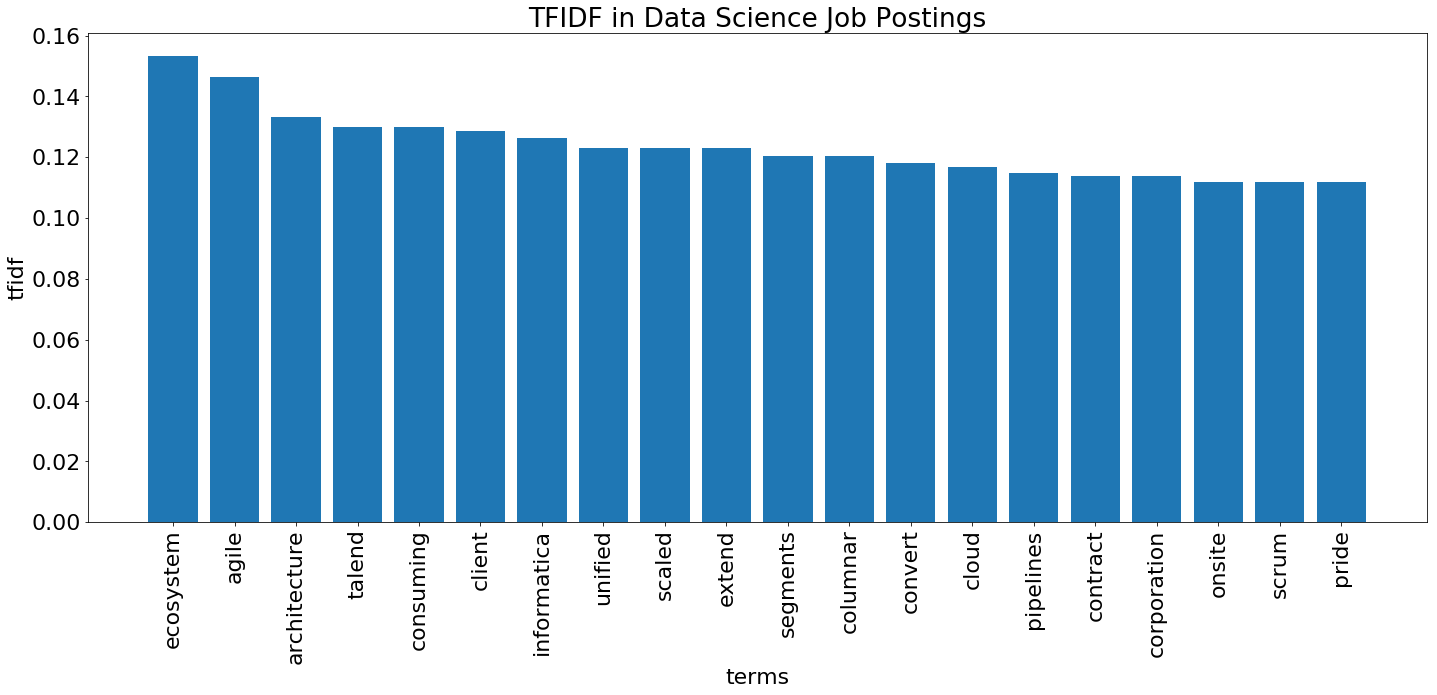

In [372]:
fig, ax = plt.subplots(figsize=(24,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('tfidf')
ax.set_title('TFIDF in Data Science Job Postings')

In [126]:
y.shape

(50,)

In [130]:
skills_vector = ['machine learning', 'python', 'java', 'hadoop', 'spark', 'data mining', 'r', 'c++', 'hive',
                'pig', 'sql', 'natural language processing', 'ai', 'nosql', 'image processing', 'tableau', 
                 'sas', 'matlab', 'embedded software', 'spss', 'oop', 'azure', 'javascript', 'sdlc', '.net', 
                 'perl', 'rest', 'big data', 'jenkins', 'oracle', 'management experience', 's3', 'jira', 
                 'json', 'shell scripting', 'test automation', 'clojure', 'data science', 'go', 'biotechnology',
                 'ci', 'project management', 'excel', 'microsoft office', 'docker', 'data analysis', 'postgresql',
                 'ruby', 'laboratory experience', 'kubernetes', 'microsoft powerpoint', 'program management',
                 'd3.js', 'git', 'data warehouse', 'html5', 'microsoft sql server', 'hbase', 'ansible', 
                 'google cloud platform', 'unit testing', 'node.js', 'php', 'react', 'marketing', 'spring',
                 'maven', 'signal processing', 'power bi', 'mysql', 'scripting', 'svn', 'angular', 
                 'time management', 'analysis skills', 'visual basic', 'kafka', 'molecular biology','dynamodb',
                 'system design', 'weka', 'leadership experience', 'sentiment analytics', 'mirosoft word', 'sap',
                 'software development', 'clinical research', 'mongodb', 'predictive analytics', 
                 'statistical analytics', 'genetics', 'cloud computing', 'visual studio', 'cassandra', 
                 'supply chain experience', 'erp systems']
skeelz=set(skills_vector)

In [456]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', vocabulary=skeelz)
#tfidf.vocabulary
tfidf.fit(dfclean['job_description'])
bag_of_words = tfidf.fit_transform(dfclean['job_description'])

feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(bag_of_words.toarray()).flatten()[::-1]

n = 50
X = feature_array[tfidf_sorting][:n]
y = np.sort(bag_of_words.toarray()).flatten()[::-1]
y=y[:n]

/Users/michaelpalmer/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [486]:
bag_of_words.

<609x96 sparse matrix of type '<class 'numpy.float64'>'
	with 3606 stored elements in Compressed Sparse Row format>

In [484]:
#1282
#total tfidf score for each word
#y=bag_of_words.sum(axis=0)
#X=tfidf.get_feature_names()
y=np.sort(bag_of_words.sum(axis=0))

In [485]:
y

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.43789806,  0.43964865,
          0.56704444,  0.64557466,  0.83154876,  0.86881274,  0.89935814,
          1.27071685,  1.41586609,  1.46164509,  1.50168906,  1.55428681,
          1.89329074,  1.95141689,  2.22066239,  3.00672493,  3.18260605,
          3.26697025,  3.28731886,  3.40924166,  3.44193105,  3.45522465,
          3.47764297,  3.82952142,  4.42737254,  4.69176902,  4.92065003,
          5.22262852,  5.36635195,  5.56992731,  5.92234401,  6.02251988,
          6.41908557,  6.81773191,  6.85313157,  7.1699585 ,  7.53890908,
          7.90905913,  7.92096894,  8.27654814,  8.35778281,  9.80151973,
         10.11554988, 11.18845894, 12.52568297, 12.67318363, 12.79991157,
         13.50102918, 13.82584545, 14.

Text(0.5,1,'TFIDF in Data Science Job Postings')

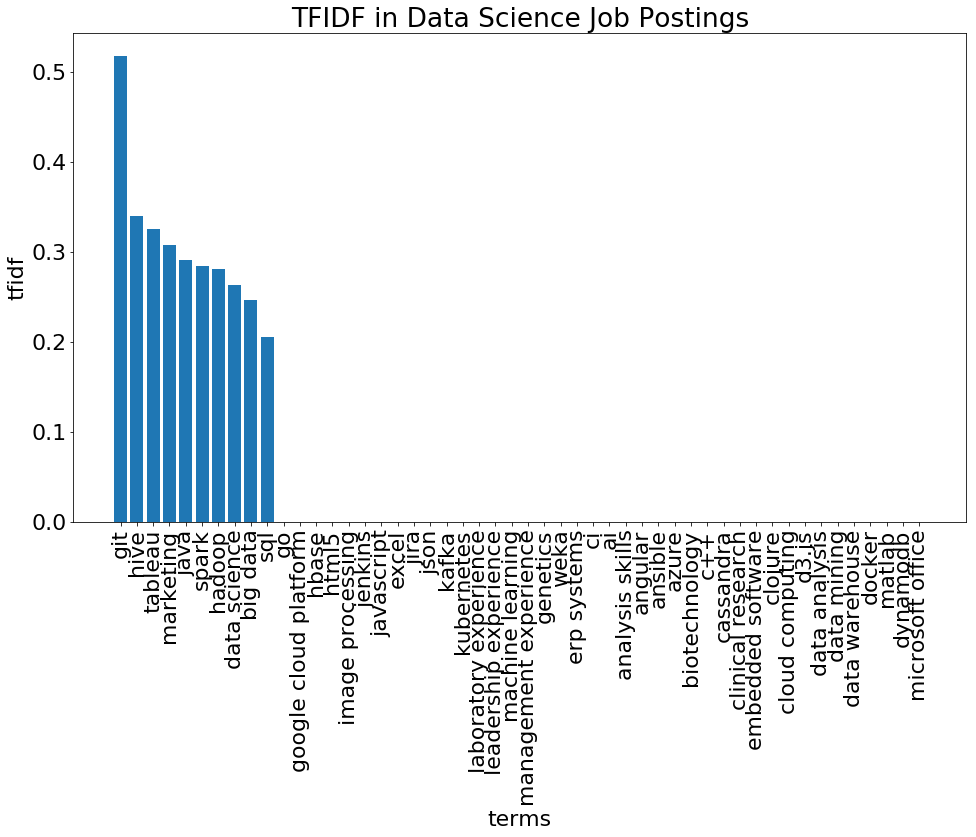

In [457]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('tfidf')
ax.set_title('TFIDF in Data Science Job Postings')

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33159761, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [156]:
np.sort(bag_of_words.toarray()).flatten()[::-1].shape

(58464,)

In [207]:
cvec=CountVectorizer(stop_words='english', vocabulary=skeelz)
cvec.fit(dfclean['job_description'])
bag_of_words=cvec.transform(dfclean['job_description'])
bag_of_words_document_ind = bag_of_words>0
sum_words = bag_of_words.sum(axis=0) 
count_words = bag_of_words_document_ind.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in     cvec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#return words_freq[:n]

Text(0.5,1,'Document Frequency in Data Science Job Postings')

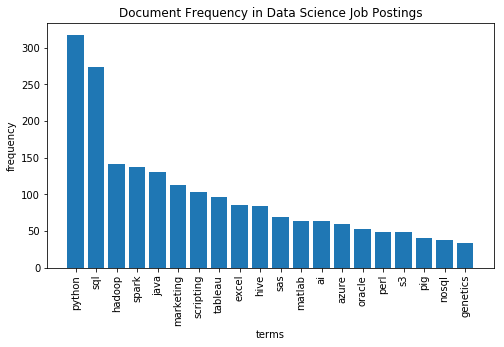

In [356]:
#bag_of_words.toarray().count()
#cvec.vocabulary_.items()
#count_words
doc_freq = [(word, count_words[0, idx]) for word, idx in     cvec.vocabulary_.items()]
doc_freq =sorted(doc_freq, key = lambda x: x[1], reverse=True)
doc_freq
arr=np.array(doc_freq[:20])
X=arr[:,0]
y=arr[:,1]
y=y.astype(int)
fig, ax = plt.subplots(figsize=(8,4.5))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('frequency')
ax.set_title('Document Frequency in Data Science Job Postings')

In [192]:
#bag_of_words.sum(axis=0)
#cvec.vocabulary_
np.sort(bag_of_words.count(axis=0))
np.argsort(bag_of_words.sum(axis=0)) 
bag_of_words.count(axis=0)
#[::-1]
#cvec.vocabulary_

AttributeError: count not found

In [360]:
from matplotlib import rcParams
rcParams.update({'font.size': 22})

Text(0.5,1,'Term Frequency in Data Science Job Postings')

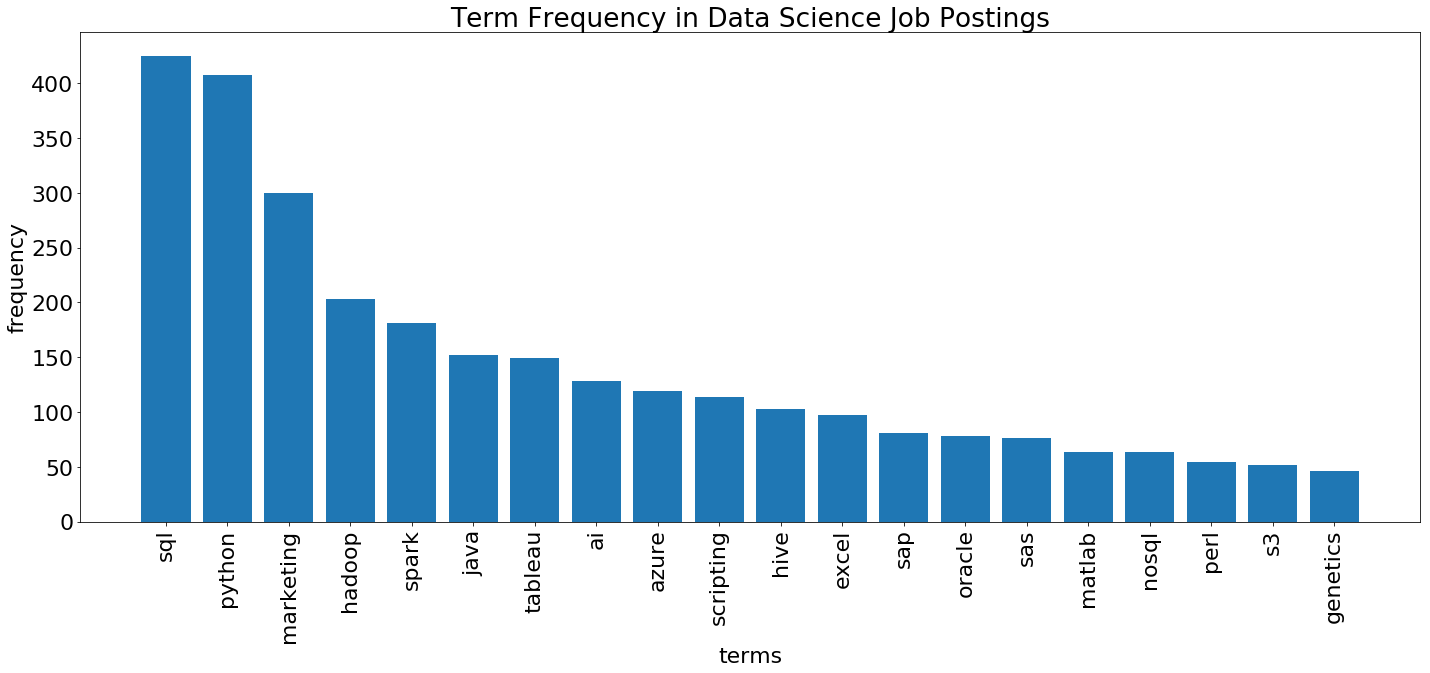

In [362]:
arr=np.array(words_freq[:20])
X=arr[:,0]
y=arr[:,1]
y=y.astype(int)
fig, ax = plt.subplots(figsize=(24,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('frequency')
ax.set_title('Term Frequency in Data Science Job Postings')


In [214]:
from sklearn.linear_model import LinearRegression

/Users/michaelpalmer/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [217]:
#bag_of_words
bag_of_words>0

<609x96 sparse matrix of type '<class 'numpy.bool_'>'
	with 2334 stored elements in Compressed Sparse Row format>

In [247]:
not_python=(bag_of_words[:,cvec.vocabulary_['python']]==0).toarray()
not_sql=(bag_of_words[:,cvec.vocabulary_['sql']]==0).toarray()
[not_sql&not_python]
dfclean['job_description'][0]

/Users/michaelpalmer/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


'Senior Data Scientist or Data Scientist #88345\nJOB SUMMARY: Puget Sound Energys Strategic Customer Insights Group is looking for a Data Scientist to join our team. This role works in a team that is designed to attain the companys strategic goals via the extensive use of data and analysis to drive decisions and actions. The ideal candidate will be responsible for the continuous improvement of PSEs competitiveness as an energy partner in the northwest through an analytical focus on customer experience.\n\nAt the discretion of the hiring team, this position may be filled as a senior data scientist or data scientist depending on the qualifications of the selected candidate.\n\nFamilies and businesses depend on PSE to provide the energy they need to pursue their dreams. Our steadfast commitment to serving Washington communities with safe, dependable and efficient energy started in 1886. Today were building the Northwests energy future through efforts like our award winning energy efficien

In [ ]:
#fit model

In [294]:
X = bag_of_words

In [295]:
dfclean

,job_title,job_description,stars,salary_lower,salary_upper,salary_estimator,avg_salary
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,120,170,(Glassdoor Est.),145.0
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,90,127,(Glassdoor Est.),108.5
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,120,169,(Glassdoor Est.),144.5
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,108,155,(Glassdoor Est.),131.5
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,118,173,(Glassdoor Est.),145.5
5,Data Scientist,At a time when healthcare reform is on the nat...,4.0 ★,119,170,(Glassdoor Est.),144.5
6,Data Architect,Yesler is looking for an expert Data Architect...,4.4 ★,83,120,(Glassdoor Est.),101.5
7,Data Scientist,Who we are:\n\nRover.com connects pet parents ...,4.5 ★,82,121,(Glassdoor Est.),101.5
8,Bioinformatics Scientist,We are seeking a Bioinformatics Scientist for ...,3.2 ★,88,118,(Glassdoor Est.),103.0
9,Data Scientist,The Intelligent Conversation and Communication...,4.1 ★,118,160,(Glassdoor Est.),139.0


In [526]:
dfclean['avg_salary'] = ( dfclean['salary_lower'] + dfclean['salary_upper'] )/2

In [296]:
y = dfclean['avg_salary']

In [297]:
model=LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [273]:
#model.predict(X_test)

In [298]:
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(y_train, y_train_predict))
rmse_test=np.sqrt(mean_squared_error(y_test, y_predict))
benchmark_test = np.full(len(y_test),y_train.mean())
benchmark_rmse = np.sqrt(mean_squared_error(y_test, benchmark_test))
print(rmse_train, rmse_test, benchmark_rmse)
np.argsort(model.coef_)
#lowest 87, 3, 53, 39, 61
#highest 46, 12, 60, 95, 20
model.coef_[46]
model.intercept_

28.15697127190307 33.678144537206926 37.68314107196617


108.29779411764706

In [305]:
model =  RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(y_train, y_train_predict))
rmse_test=np.sqrt(mean_squared_error(y_test, y_predict))
benchmark_test = np.full(len(y_test),y_train.mean())
benchmark_rmse = np.sqrt(mean_squared_error(y_test, benchmark_test))
print(rmse_train, rmse_test, benchmark_rmse)


15.139595322558494 26.758946941792985 37.68314107196617


AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [307]:
bag_of_words[46]

<1x96 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [306]:
model = Ridge()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(y_train, y_train_predict))
rmse_test=np.sqrt(mean_squared_error(y_test, y_predict))
benchmark_test = np.full(len(y_test),y_train.mean())
benchmark_rmse = np.sqrt(mean_squared_error(y_test, benchmark_test))
print(rmse_train, rmse_test, benchmark_rmse)
np.argsort(model.coef_)
#51, 87, 53, 11, 23
#42, 70, 48, 30, 12

27.923180377120243 29.42409080614871 37.68314107196617


array([51, 87, 53, 11, 23, 61, 40,  3, 29, 91, 89, 81, 25, 62, 15, 24, 56,
       64, 47, 93, 49, 50, 90, 88, 94, 54, 55, 57, 77, 68, 85, 86,  0, 14,
       21, 26, 27,  8, 31, 39, 84, 67, 37, 52, 18, 58, 10,  4, 92, 83, 28,
       17, 82, 59, 73, 34, 74, 35, 79, 22, 20, 69, 78, 36,  6, 45, 43, 72,
       13, 19,  2, 63, 66, 65, 76, 46, 16,  7, 95, 71,  9, 75, 80, 60,  1,
       41, 33, 38, 44,  5, 32, 12, 30, 48, 70, 42])

In [287]:
bag_of_words[46].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

In [290]:
cvec.vocabulary_['sql']

84

In [291]:
cvec.vocabulary_

{'.net': 0,
 'ai': 1,
 'analysis skills': 2,
 'angular': 3,
 'ansible': 4,
 'azure': 5,
 'big data': 6,
 'biotechnology': 7,
 'c++': 8,
 'cassandra': 9,
 'ci': 10,
 'clinical research': 11,
 'clojure': 12,
 'cloud computing': 13,
 'd3.js': 14,
 'data analysis': 15,
 'data mining': 16,
 'data science': 17,
 'data warehouse': 18,
 'docker': 19,
 'dynamodb': 20,
 'embedded software': 21,
 'erp systems': 22,
 'excel': 23,
 'genetics': 24,
 'git': 25,
 'go': 26,
 'google cloud platform': 27,
 'hadoop': 28,
 'hbase': 29,
 'hive': 30,
 'html5': 31,
 'image processing': 32,
 'java': 33,
 'javascript': 34,
 'jenkins': 35,
 'jira': 36,
 'json': 37,
 'kafka': 38,
 'kubernetes': 39,
 'laboratory experience': 40,
 'leadership experience': 41,
 'machine learning': 42,
 'management experience': 43,
 'marketing': 44,
 'matlab': 45,
 'maven': 46,
 'microsoft office': 47,
 'microsoft powerpoint': 48,
 'microsoft sql server': 49,
 'mirosoft word': 50,
 'molecular biology': 51,
 'mongodb': 52,
 'mysql': 5

In [303]:
model =  Lasso()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(y_train, y_train_predict))
rmse_test=np.sqrt(mean_squared_error(y_test, y_predict))
benchmark_test = np.full(len(y_test),y_train.mean())
benchmark_rmse = np.sqrt(mean_squared_error(y_test, benchmark_test))
print(rmse_train, rmse_test, benchmark_rmse)

33.73025487185268 33.43483298975494 37.68314107196617


In [319]:
from scipy.stats import gaussian_kde
density = gaussian_kde(dfclean['avg_salary'])

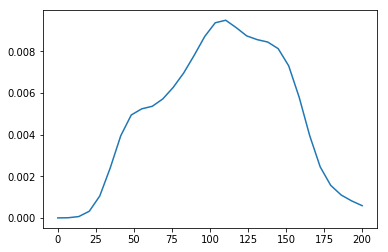

In [328]:
xs = np.linspace(0,200,30)
plt.plot(xs,density(xs))
plt.show()

/Users/michaelpalmer/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'density')

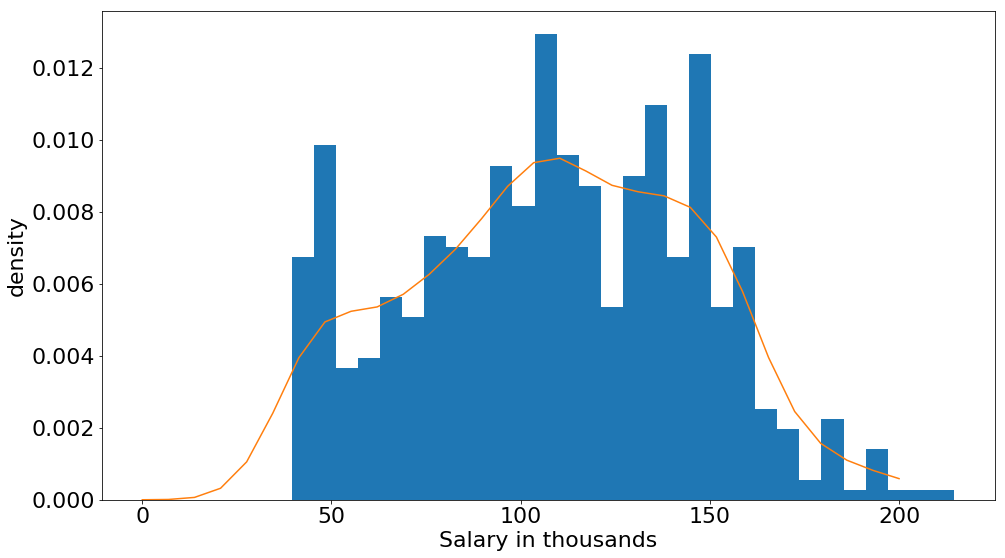

In [363]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(dfclean['avg_salary'], bins=30, normed=True)
ax.plot(xs,density(xs))
ax.set_xlabel('Salary in thousands')
ax.set_ylabel('density')

In [378]:
data_visualization_front_end_skills = ['ggplot', 'power bi', 'data visualization', 'matplotlib', 'tableau', 'powerbi', 'excel', 'seaborn', 'd3.js', 'processing.js', 'polymaps', 'sigma js', 'n3-charts', 'chartist.js', 'leaflet', 'chart.js', 'highcharts', 'fusioncharts', 'google charts', 'NVD3', 'Ember Charts', 'Visual.ly', 'Plotly', 'Qlikview', 'Datawrapper', 'flask', 'html5', 'html', 'angular', 'react', 'rest']
management_skills = ['project management', 'agile', 'scrum', 'direct reports', 'communication', 'jira', 'management experience', 'time management', 'public speaking', 'leadership experience', 'program management', 'team player', 'erp systems', 'maven', 'sap', 'sdlc']
machine_learning = ['sklearn', 'decision trees', 'random forests', 'random forest', 'neural networks', 'keras', 'gradient boosting', 'deep learning', 'naive bayes', 'ai', 'natural language processing', 'selenium', 'nlp', 'svm', 'tensorflow', 'data mining', 'decision tree', 'rnn', 'cnn', 'machine learning', 'gradient descent', 'overfitting', 'underfitting', 'neural network', 'recommender systems', 'tfidf', 'pytorch', 'weka']
programming = ['c++', 'c#', 'python', 'java', 'javascript', 'numpy', 'node.js', 'oop', 'pandas', 'r', 'perl', 'software engineering', 'scripting', 'visual basic', 'visual studio', 'web scraping', 'svn', 'embedded software', 'go', 'git', 'php', 'test automation', 'ruby', '.net', 'unit testing', 'shell scripting', 'software development', 'jenkins', 'clojure', 'spring']
cloud_computing = ['aws', 's3', 'azure', 'google cloud', 'bigtable', 'cloud computing', 'google cloud platform']
math_statistics = ['linear regression', 'logistic regression', 'bayes', 'ab testing', 'a/b testing', 'bayesian', 'bernoulli', 'calculus', 'confidence intervals', 'cosine similarity', 'cross validation', 'game theory', 'matrix factorization', 'linear algebra', 'multi arm bandit', 'poisson', 'optimization', 'statistical analysis', 'statistical analytics', 'matlab', 'spss', 'mathematics', 'experimental design', 'boosting', 'numerical analysis', 'classification', 'scipy', 'regression', 'predictive analytics', 'sas', 'pricing optimization', 'time series', 'statistics']
education = ['bachelor''s', 'master''s', 'doctoral', 'doctorate', 'ms', 'advanced degree', 'phd']
data_engineering = ['sql', 'etl', 'data warehousing', 'data warehouse', 'distributed systems', 'dynamodb', 'mongodb', 'engineering', 'nosql', 'oracle', 'json', 'postgresql', 'pig', 'pyspark', 'scala', 'spark', 'data wrangler', 'hive', 'hadoop', 'mysql', 'big data', 'teradata', 'cassandra', 'networking', 'ansible', 'ci', 'docker', 'kafka', 'hbase', 'kubernetes']
problem_solving = ['analysis skills', 'analytical', 'analyze', 'system design', 'accuracy', 'data science', 'model testing', 'modeling', 'precision', 'recall', 'profit curve', 'roc curve', 'microsoft word', 'mirosoft word', 'microsoft office', 'microsoft powerpoint', 'microsoft sql server', 'millions of rows', 'data analysis', 'marketing attribution', 'problem solving', 'recommendation', 'profit curves', 'sentiment analytics']
miscellaneous = ['genetics', 'biotechnology','molecular biology', 'media mixing model', 'inventory model', 'image processing', 'signal processing', 'supply chain experience', 'customer lifetime value', 'laboratory experience', 'product ranking', 'trials']

In [380]:
skills_partition={'data_visualization_front_end_skills': data_visualization_front_end_skills, 'management_skills': management_skills, 'machine_learning': machine_learning, 'programming': programming, 'cloud_computing': cloud_computing, 'math_statistics': math_statistics, 'education': education, 'data_engineering': data_engineering, 'problem_solving': problem_solving, 'miscellaneous': miscellaneous}

In [396]:
cols=list(skills_partition.keys())
#cols.append('vocab_words_used')

In [527]:
for k,v in skills_partition.items():
    cvec = CountVectorizer(vocabulary=v)
    x = cvec.fit_transform(dfclean['job_description'].values.astype('U'))
    tokens = cvec.get_feature_names()
    y = pd.DataFrame(x.toarray(), columns=tokens)
    dfclean[k]=y.sum(axis=1)

In [509]:
#skills_partition.values()
v=data_visualization_front_end_skills
cvec=CountVectorizer(vocabulary=v)
x=cvec.fit_transform(dfclean['job_description'].values.astype('U'))
tokens = cvec.get_feature_names()
y = pd.DataFrame(x.toarray(), columns=tokens)

In [528]:
#dfclean['job_description'][856]
#dfclean[dfclean['data_visualization_front_end_skills'].isnull()]
#y.sum(axis=1)
dfclean

,job_title,job_description,stars,salary_lower,salary_upper,salary_estimator,avg_salary,data_visualization_front_end_skills,management_skills,machine_learning,programming,cloud_computing,math_statistics,education,data_engineering,problem_solving,miscellaneous
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,120,170,(Glassdoor Est.),145.0,1,0,0,0,0,2,0,0,5,0
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,90,127,(Glassdoor Est.),108.5,0,0,0,5,0,4,1,4,2,0
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,120,169,(Glassdoor Est.),144.5,0,0,0,2,0,5,1,0,3,0
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,108,155,(Glassdoor Est.),131.5,2,0,0,1,0,3,0,2,2,0
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,118,173,(Glassdoor Est.),145.5,1,2,2,2,0,2,1,5,2,0
5,Data Scientist,At a time when healthcare reform is on the nat...,4.0 ★,119,170,(Glassdoor Est.),144.5,0,0,0,2,2,4,1,4,2,0
6,Data Architect,Yesler is looking for an expert Data Architect...,4.4 ★,83,120,(Glassdoor Est.),101.5,0,1,1,1,0,0,0,6,0,0
7,Data Scientist,Who we are:\n\nRover.com connects pet parents ...,4.5 ★,82,121,(Glassdoor Est.),101.5,1,3,0,1,0,0,2,2,3,0
8,Bioinformatics Scientist,We are seeking a Bioinformatics Scientist for ...,3.2 ★,88,118,(Glassdoor Est.),103.0,0,2,0,3,0,0,1,0,0,0
9,Data Scientist,The Intelligent Conversation and Communication...,4.1 ★,118,160,(Glassdoor Est.),139.0,0,0,0,1,0,3,1,1,1,0


In [397]:
cols

['data_visualization_front_end_skills',
 'management_skills',
 'machine_learning',
 'programming',
 'cloud_computing',
 'math_statistics',
 'education',
 'data_engineering',
 'problem_solving',
 'miscellaneous']

In [405]:
dfclean[cols] = dfclean[cols].fillna(0)

In [434]:
dfclean

,job_title,job_description,stars,salary_lower,salary_upper,salary_estimator,avg_salary,data_visualization_front_end_skills,management_skills,machine_learning,programming,cloud_computing,math_statistics,education,data_engineering,problem_solving,miscellaneous
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,120,170,(Glassdoor Est.),145.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.413754,0.000000,0.000000,1.455227,0.0
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,90,127,(Glassdoor Est.),108.5,0.000000,0.000000,0.000000,1.979653,0.000000,1.406414,1.000000,1.281019,1.000000,0.0
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,120,169,(Glassdoor Est.),144.5,0.000000,0.000000,0.000000,1.370778,0.000000,1.672852,1.000000,0.000000,1.726819,0.0
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,108,155,(Glassdoor Est.),131.5,1.413909,0.000000,0.000000,1.000000,0.000000,1.268376,0.000000,1.412960,1.414061,0.0
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,118,173,(Glassdoor Est.),145.5,1.000000,1.369818,1.409970,1.383302,0.000000,1.402707,1.000000,1.956157,1.341883,0.0
5,Data Scientist,At a time when healthcare reform is on the nat...,4.0 ★,119,170,(Glassdoor Est.),144.5,0.000000,0.000000,0.000000,1.281946,1.403411,1.674757,1.000000,1.930420,1.000000,0.0
6,Data Architect,Yesler is looking for an expert Data Architect...,4.4 ★,83,120,(Glassdoor Est.),101.5,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.877675,0.000000,0.0
7,Data Scientist,Who we are:\n\nRover.com connects pet parents ...,4.5 ★,82,121,(Glassdoor Est.),101.5,1.000000,1.409267,0.000000,1.000000,0.000000,0.000000,1.413069,1.412960,1.366191,0.0
8,Bioinformatics Scientist,We are seeking a Bioinformatics Scientist for ...,3.2 ★,88,118,(Glassdoor Est.),103.0,0.000000,1.369818,0.000000,1.663129,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
9,Data Scientist,The Intelligent Conversation and Communication...,4.1 ★,118,160,(Glassdoor Est.),139.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.697991,1.000000,1.000000,1.000000,0.0


In [529]:
X=dfclean[cols]

In [530]:
y = dfclean['avg_salary']

In [531]:
model=RandomForestRegressor(n_estimators=1000)
#model=LinearRegression()

In [532]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [533]:
#len(y_test)

In [534]:
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(y_train, y_train_predict))
rmse_test=np.sqrt(mean_squared_error(y_test, y_predict))
benchmark_test = np.full(len(y_test),y_train.mean())
benchmark_rmse = np.sqrt(mean_squared_error(y_test, benchmark_test))
print(rmse_train, rmse_test, benchmark_rmse)

14.204862604080684 31.72162461452668 37.72523744138438


In [535]:
quote_skills_quote=['chocolate', 'python']

In [ ]:
new_input = 'chocolate python'
best_skillset = new_input
best_salary = model.predict(enhance_features(tfidf.transform([new_input]).toarray()))
for word in vocab:
    improved_skillset = new_input + ' ' + word
    vectorized_new_input = enhance_features(tfidf.transform([improved_skillset]).toarray())
    if model.predict(vectorized_new_input) < best_salary:
        best_salary = model.predict(vectorized_new_input)
        best_skillset = improved_skillset

In [417]:
model.predict(np.zeros(len(cols)))

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [418]:
len(cols)

10

In [565]:
def vectorize_input(initial_skills, skills_partition):
    '''
    given initial set of skills transform data into vectorized buckets of skills
    for example skills_partition might have programming of which C++ and python roll up to
    if both of these skills are present in our initial skillset we have a 2 in the programming bucket
    '''
    vals=[]
    for k,v in skills_partition.items():
        cvec = CountVectorizer(vocabulary=v)
        x = cvec.fit_transform([initial_skills])
        tokens = cvec.get_feature_names()
        y = pd.DataFrame(x.toarray(), columns=tokens)
        vals.append(float(y.sum(axis=1)))
    return np.array(vals)

In [584]:
initial_skills = 'machine learning python sql c++ r marketing powerbi statistics linear regression neural networks'
initial_skills_vector = vectorize_input(initial_skills, skills_partition)
initial_salary = model.predict(vectorize_input(initial_skills, skills_partition).reshape(1,-1))
best_salary = model.predict(vectorize_input(initial_skills, skills_partition).reshape(1,-1))
#for skill_group in #skill_groups (i.e. partition names):
    

array([115.87417976])

In [555]:
v = skills_partition['data_visualization_front_end_skills']
cvec = CountVectorizer(vocabulary=v)
x = cvec.fit_transform([initial_skills])
tokens = cvec.get_feature_names()
y = pd.DataFrame(x.toarray(), columns=tokens)
float(y.sum(axis=1))

0    0
dtype: int64

In [716]:
#deciles! dont even have to use quantile function
dfclean['salary_decile'] = pd.qcut(dfclean['avg_salary'],10,labels=False)

In [837]:
cols2

['data_visualization_front_end_skills',
 'management_skills',
 'machine_learning',
 'programming',
 'cloud_computing',
 'math_statistics',
 'education',
 'data_engineering',
 'problem_solving',
 'miscellaneous',
 'average_salary']

In [853]:
cols2 = cols.copy()
#cols2.append('avg_salary')
cols2 = ['avg_salary']
salary_decile = pd.DataFrame(dfclean.groupby('salary_decile').mean()['avg_salary'])

#dfclean
#salary_decile.append()

In [723]:
dfclean.groupby('salary_decile').sum()[cols]

,data_visualization_front_end_skills,management_skills,machine_learning,programming,cloud_computing,math_statistics,education,data_engineering,problem_solving,miscellaneous
salary_decile,,,,,,,,,,
0,20,46,0,32,0,32,54,65,63,50
1,22,37,2,47,16,44,24,77,66,21
2,42,68,17,66,16,76,47,174,80,24
3,47,52,31,65,34,119,44,221,114,8
4,38,86,6,115,62,96,35,326,128,8
5,33,52,17,110,65,102,25,383,114,11
6,33,99,42,127,45,124,38,224,104,8
7,20,44,47,133,78,106,40,304,115,5
8,16,42,43,106,51,118,47,240,112,4


In [731]:
cvec=CountVectorizer(stop_words='english', vocabulary=skeelz)
cvec.fit(dfclean['job_description'])
bag_of_words=cvec.transform(dfclean['job_description'])

['sklearn',
 'decision trees',
 'random forests',
 'random forest',
 'neural networks',
 'keras',
 'gradient boosting',
 'deep learning',
 'naive bayes',
 'ai',
 'natural language processing',
 'selenium',
 'nlp',
 'svm',
 'tensorflow',
 'data mining',
 'decision tree',
 'rnn',
 'cnn',
 'machine learning',
 'gradient descent',
 'overfitting',
 'underfitting',
 'neural network',
 'recommender systems',
 'tfidf',
 'pytorch',
 'weka']

In [776]:
y

,data_visualization_front_end_skills,management_skills,machine_learning,programming,cloud_computing,math_statistics,education,data_engineering,problem_solving,miscellaneous
salary_decile,,,,,,,,,,
0,0.327869,0.754098,0.000000,0.524590,0.000000,0.524590,0.885246,1.065574,1.032787,0.819672
1,0.360656,0.606557,0.032787,0.770492,0.262295,0.721311,0.393443,1.262295,1.081967,0.344262
2,0.677419,1.096774,0.274194,1.064516,0.258065,1.225806,0.758065,2.806452,1.290323,0.387097
3,0.746032,0.825397,0.492063,1.031746,0.539683,1.888889,0.698413,3.507937,1.809524,0.126984
4,0.633333,1.433333,0.100000,1.916667,1.033333,1.600000,0.583333,5.433333,2.133333,0.133333
5,0.540984,0.852459,0.278689,1.803279,1.065574,1.672131,0.409836,6.278689,1.868852,0.180328
6,0.568966,1.706897,0.724138,2.189655,0.775862,2.137931,0.655172,3.862069,1.793103,0.137931
7,0.322581,0.709677,0.758065,2.145161,1.258065,1.709677,0.645161,4.903226,1.854839,0.080645
8,0.262295,0.688525,0.704918,1.737705,0.836066,1.934426,0.770492,3.934426,1.836066,0.065574


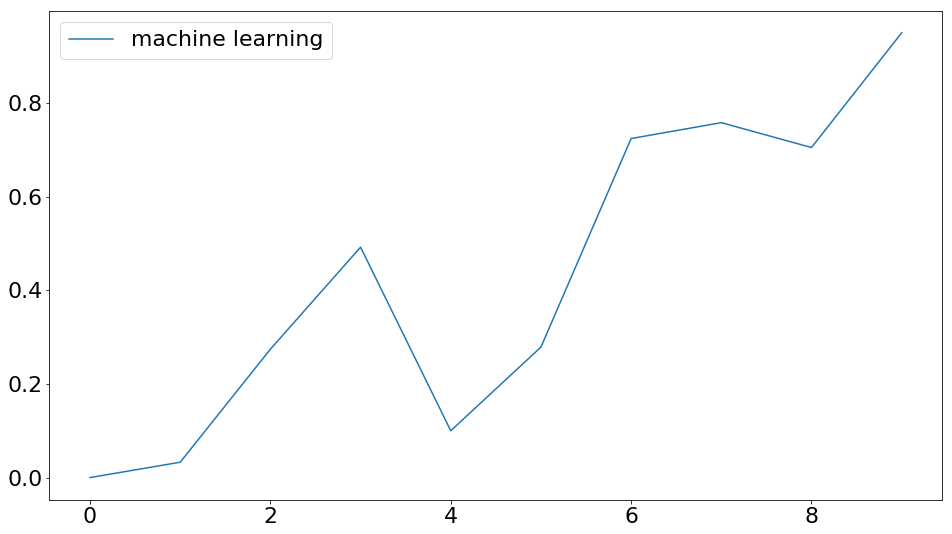

In [786]:
y=dfclean.groupby('salary_decile').mean()['machine_learning']
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(x,y)
ax.legend(['machine learning'])
#label = 'machine learning'

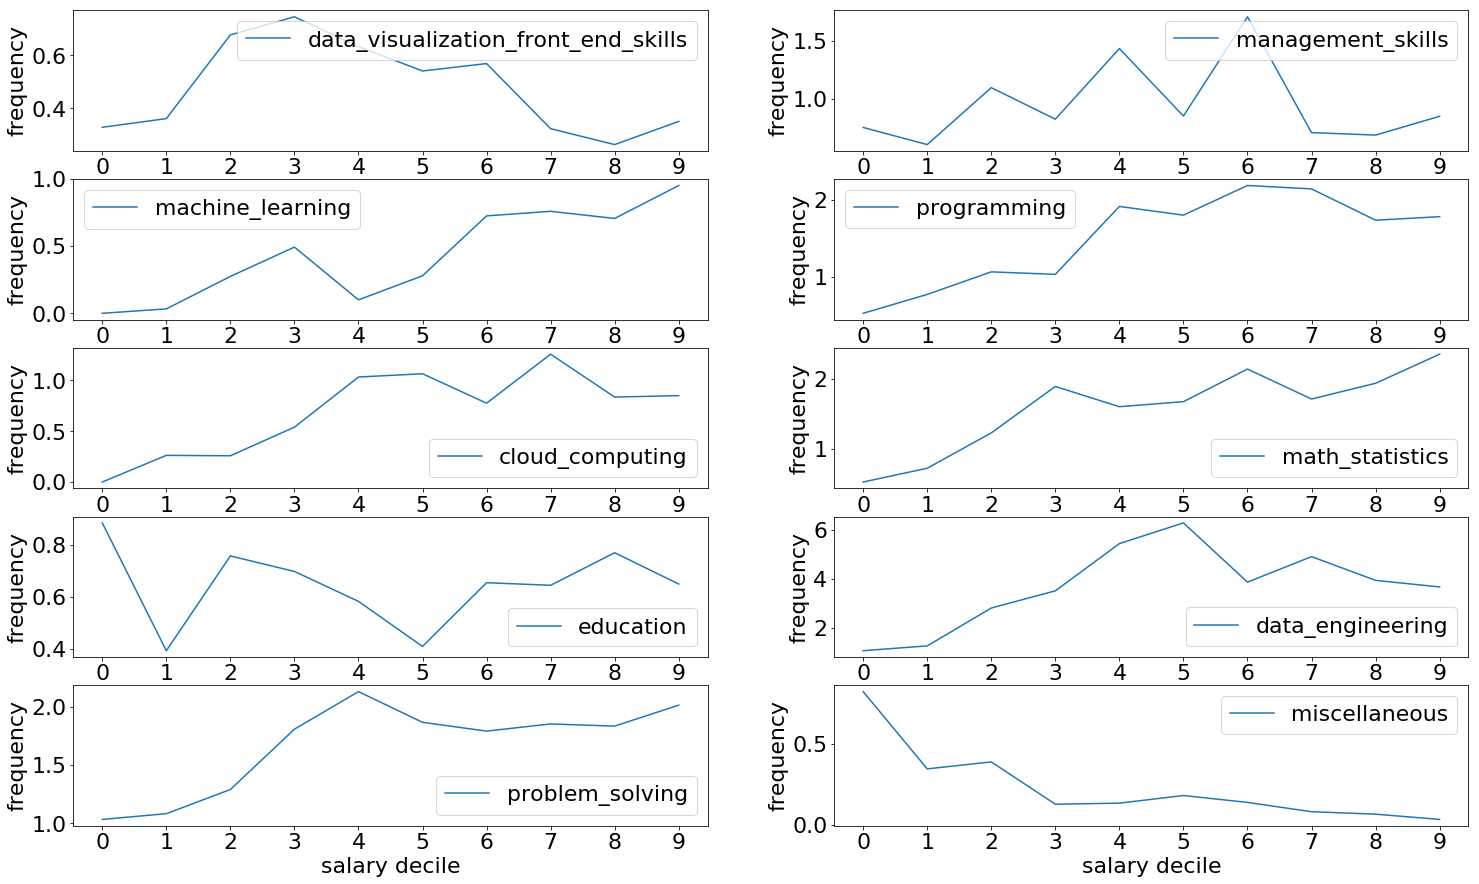

In [805]:
#x=dfclean.groupby('salary_decile').mean().index
#y=
#y=dfclean.groupby('salary_decile').mean()[cols]

#y

fig, axs = plt.subplots(5,2, figsize=(25,15))
axs = axs.flatten()
for ax, col in zip(axs,cols):
    y=dfclean.groupby('salary_decile').mean()[col]
    x=y.index
    ax.plot(x,y)
    ax.legend([col])
    ax.set_xticks(range(10))
    ax.set_xlabel('salary decile')
    ax.set_ylabel('frequency')

#label=y.columns
#

In [850]:
common_titles = pd.DataFrame(dfclean.groupby(['salary_decile']).agg(lambda x:x.value_counts().index[0])['job_title'])

In [630]:
def get_top_20_skills(df,textcol,skillsvocab):
    cvec=CountVectorizer(vocabulary=skillsvocab)
    x=cvec.fit_transform(df[textcol].values.astype('U'))
    tokens = cvec.get_feature_names()
    y = pd.DataFrame(x.toarray(), columns=tokens)
    res = pd.DataFrame(y.sum(axis=0))
    res = res.reset_index()
    res.columns = ['skill', 'count']
    return res.sort_values(by='count', ascending=False)[:20]

In [678]:
def calc_salary_deciles():
    salary_deciles=[]

    for i in range(1,10):
        salary_deciles.append(dfclean['avg_salary'].quantile(i/10))
    return salary_deciles


In [ ]:
def get_salaries_in_range(df,lower_sal,upper_sal):
    '''returns only salaries between range from input df'''
    return df[df['avg_salary'].between(lower_sal,upper_sal)

In [765]:
#top_decile[cols].sum(axis=0)
dfclean.groupby(['salary_decile'])['job_description'].apply(lambda x: np.mean(x.str.len()))
#top_decile['job_description'].apply(len).mean()

salary_decile
0    5057.163934
1    3494.491803
2    4386.967742
3    3485.507937
4    3759.300000
5    3730.540984
6    3949.741379
7    3639.370968
8    3603.344262
9    3450.633333
Name: job_description, dtype: float64

In [829]:
###given i have above average math skills how do i grow as a data scientist?
###find postings requiring > avg math skills
###what is skill/salary distribution of those positions
filtered_df = dfclean[dfclean['math_statistics']>1]
filtered_df['salary_decile'] = pd.qcut(filtered_df['avg_salary'],10,labels=False)

/Users/michaelpalmer/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [830]:
filtered_df.head()

,job_title,job_description,stars,salary_lower,salary_upper,salary_estimator,avg_salary,data_visualization_front_end_skills,management_skills,machine_learning,programming,cloud_computing,math_statistics,education,data_engineering,problem_solving,miscellaneous,salary_decile
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,120,170,(Glassdoor Est.),145.0,1,0,0,0,0,2,0,0,5,0,7
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,90,127,(Glassdoor Est.),108.5,0,0,0,5,0,4,1,4,2,0,3
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,120,169,(Glassdoor Est.),144.5,0,0,0,2,0,5,1,0,3,0,7
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,108,155,(Glassdoor Est.),131.5,2,0,0,1,0,3,0,2,2,0,5
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,118,173,(Glassdoor Est.),145.5,1,2,2,2,0,2,1,5,2,0,7


In [831]:
filtered_df.groupby('salary_decile').mean()[cols]
#filtered_df.groupby('salary_decile').mean()['avg_salary']

,data_visualization_front_end_skills,management_skills,machine_learning,programming,cloud_computing,math_statistics,education,data_engineering,problem_solving,miscellaneous
salary_decile,,,,,,,,,,
0,0.708333,0.666667,0.166667,1.250000,0.041667,3.166667,0.625000,2.833333,2.166667,0.250000
1,0.904762,1.238095,0.428571,2.238095,0.238095,3.952381,0.761905,4.190476,2.238095,0.095238
2,0.782609,1.043478,0.391304,1.695652,0.478261,3.304348,0.739130,4.565217,2.956522,0.000000
3,0.409091,0.954545,0.045455,2.545455,1.090909,3.181818,0.863636,7.090909,2.863636,0.090909
4,0.571429,0.857143,0.285714,1.904762,0.380952,3.904762,0.761905,4.380952,3.190476,0.047619
5,0.739130,0.869565,0.565217,2.434783,0.652174,4.217391,0.739130,3.782609,2.652174,0.000000
6,0.238095,0.666667,1.761905,2.761905,1.142857,3.857143,0.761905,4.714286,2.714286,0.000000
7,0.320000,0.880000,0.600000,2.200000,0.600000,3.480000,0.600000,4.160000,2.960000,0.040000
8,0.210526,0.473684,0.789474,2.578947,0.736842,4.052632,1.105263,4.157895,2.263158,0.157895


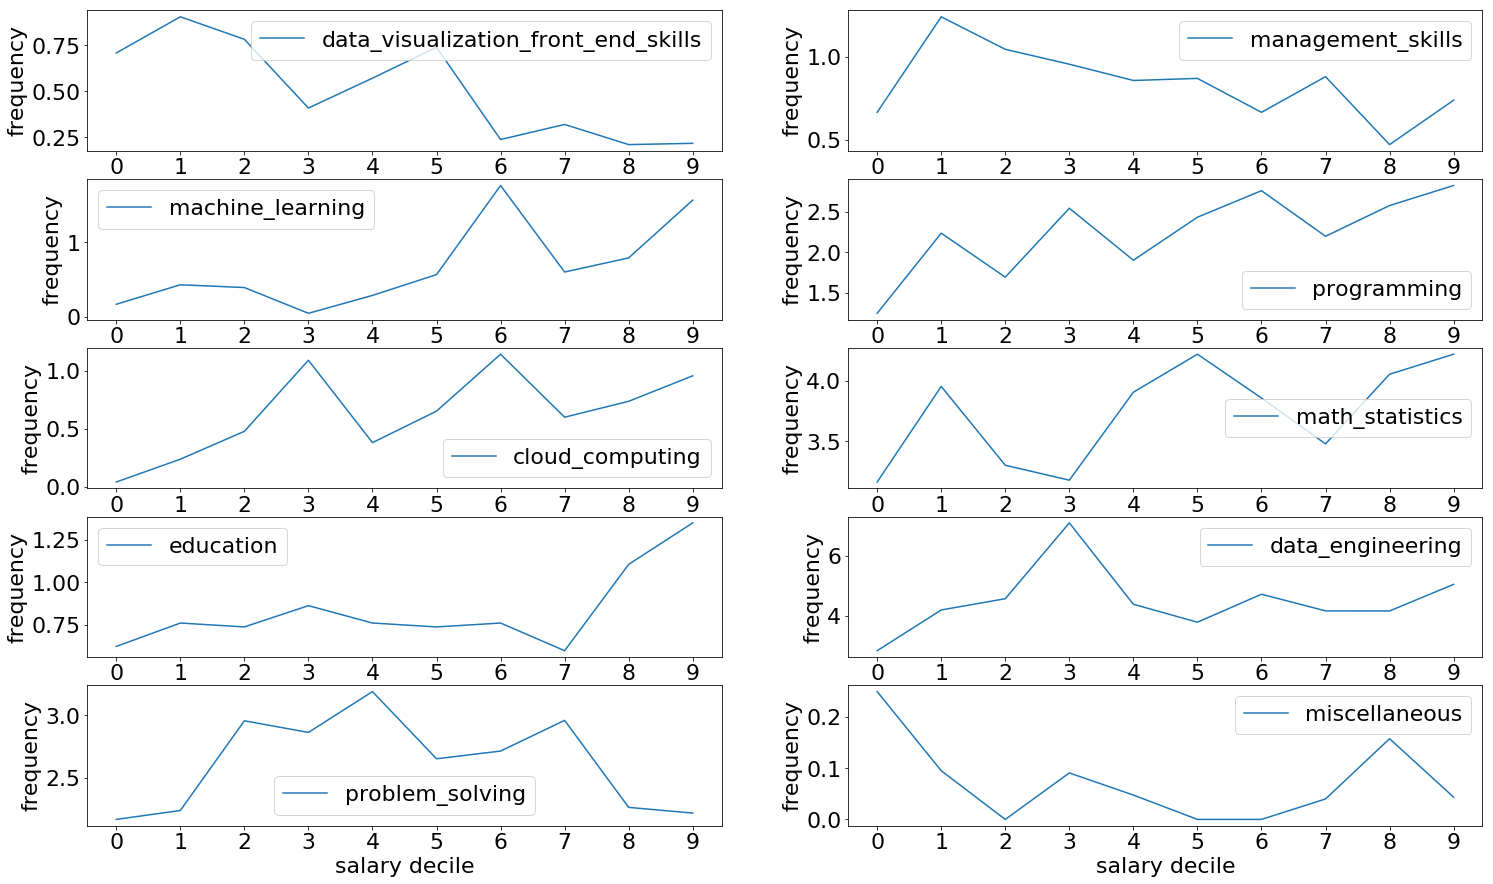

In [832]:
fig, axs = plt.subplots(5,2, figsize=(25,15))
axs = axs.flatten()
for ax, col in zip(axs,cols):
    y=filtered_df.groupby('salary_decile').mean()[col]
    x=y.index
    ax.plot(x,y)
    ax.legend([col])
    ax.set_xticks(range(10))
    ax.set_xlabel('salary decile')
    ax.set_ylabel('frequency')


In [854]:
#common_titles
salary_decile


,avg_salary
salary_decile,
0,45.311475
1,63.868852
2,81.056452
3,94.857143
4,105.641667
5,115.000000
6,127.060345
7,137.959677
8,150.245902


In [859]:
common_jobs_and_sals = common_titles.merge(salary_decile,how='inner', on='salary_decile')

In [867]:
common_jobs_and_sals.index.names = ['Salary Decile']

In [865]:
common_jobs_and_sals.columns = ['Most Common Job Title', 'Avg Salary (thousands)']

In [866]:
common_jobs_and_sals

,Most Common Job Title,Avg Salary (thousands)
Salary Decile,,
0,Data Analyst,45.311475
1,Data Analyst,63.868852
2,Technical Services Scientist,81.056452
3,Data Engineer,94.857143
4,Data Scientist,105.641667
5,Data Scientist,115.000000
6,Data Scientist,127.060345
7,Data Scientist,137.959677
8,Senior Data Scientist,150.245902
